In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ✅ Ensure timestamp_ist is datetime
trades["timestamp_ist"] = pd.to_datetime(trades["timestamp_ist"], errors="coerce")

# ✅ Create correct date from timestamp_ist
trades["date_correct"] = trades["timestamp_ist"].dt.date

# Drop rows where date is missing
trades = trades.dropna(subset=["date_correct"]).copy()

print("✅ Trades after dropping missing timestamp_ist:", trades.shape)
print("✅ date range:", trades["date_correct"].min(), trades["date_correct"].max())

# numeric conversion
for col in ["closed_pnl", "size_usd", "size_tokens", "fee"]:
    trades[col] = pd.to_numeric(trades[col], errors="coerce")

# ✅ Daily aggregation
daily = trades.groupby("date_correct").agg(
    total_pnl=("closed_pnl", "sum"),
    avg_pnl=("closed_pnl", "mean"),
    total_volume_usd=("size_usd", "sum"),
    avg_trade_usd=("size_usd", "mean"),
    trades_count=("trade_id", "count"),
    total_fee=("fee", "sum")
).reset_index().rename(columns={"date_correct": "date"})

print("✅ Daily date range:", daily["date"].min(), daily["date"].max())
display(daily.head())

# ✅ Sentiment date fix
sentiment["date"] = pd.to_datetime(sentiment["date"], errors="coerce").dt.date
sentiment["sentiment"] = sentiment["sentiment"].astype(str).str.strip().str.title()

# ✅ Merge
merged = daily.merge(sentiment[["date", "sentiment"]], on="date", how="inner")

print("✅ merged shape:", merged.shape)
print("✅ sentiment counts:\n", merged["sentiment"].value_counts())
display(merged.head())


✅ Trades after dropping missing timestamp_ist: (79225, 19)
✅ date range: 2023-01-05 2025-12-04
✅ Daily date range: 2023-01-05 2025-12-04


,date,total_pnl,avg_pnl,total_volume_usd,avg_trade_usd,trades_count,total_fee
0,2023-01-05,0.000000,0.000000,477.00,159.000000,3,0.000000
1,2023-05-12,0.000000,0.000000,50005.83,5556.203333,9,12.501455
2,2024-01-01,-129.531460,-7.196192,264239.53,14679.973889,18,66.059867
3,2024-01-02,0.000000,0.000000,2008.18,334.696667,6,0.502044
4,2024-01-03,8244.241409,60.176945,472974.70,3452.370073,137,-0.546854


✅ merged shape: (158, 8)
✅ sentiment counts:
 sentiment
Greed    115
Fear      43
Name: count, dtype: int64


,date,total_pnl,avg_pnl,total_volume_usd,avg_trade_usd,trades_count,total_fee,sentiment
0,2023-01-05,0.000000,0.000000,477.00,159.000000,3,0.000000,Fear
1,2023-05-12,0.000000,0.000000,50005.83,5556.203333,9,12.501455,Greed
2,2024-01-01,-129.531460,-7.196192,264239.53,14679.973889,18,66.059867,Greed
3,2024-01-02,0.000000,0.000000,2008.18,334.696667,6,0.502044,Greed
4,2024-01-03,8244.241409,60.176945,472974.70,3452.370073,137,-0.546854,Greed


Fear points: 43 Greed points: 115


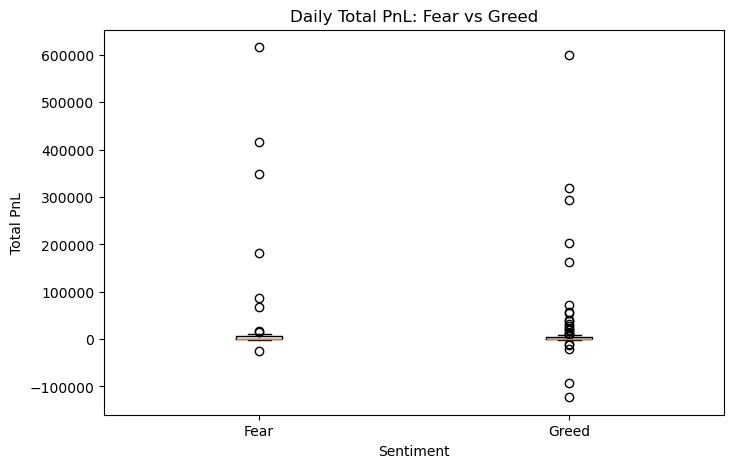

In [40]:
fear = merged.loc[merged["sentiment"] == "Fear", "total_pnl"].dropna()
greed = merged.loc[merged["sentiment"] == "Greed", "total_pnl"].dropna()

print("Fear points:", len(fear), "Greed points:", len(greed))

plt.figure(figsize=(8,5))
plt.boxplot([fear, greed], labels=["Fear", "Greed"])
plt.title("Daily Total PnL: Fear vs Greed")
plt.xlabel("Sentiment")
plt.ylabel("Total PnL")
plt.show()


In [41]:
print("merged shape:", merged.shape)
print(merged["sentiment"].value_counts())


merged shape: (158, 8)
sentiment
Greed    115
Fear      43
Name: count, dtype: int64


In [42]:
comparison = merged.groupby("sentiment").agg(
    days=("date", "count"),
    avg_total_pnl=("total_pnl", "mean"),
    median_total_pnl=("total_pnl", "median"),
    avg_volume_usd=("total_volume_usd", "mean"),
    avg_trades_per_day=("trades_count", "mean"),
    profitable_day_rate=("total_pnl", lambda x: (x > 0).mean())
).round(4)

display(comparison)


,days,avg_total_pnl,median_total_pnl,avg_volume_usd,avg_trades_per_day,profitable_day_rate
sentiment,,,,,,
Fear,43,41479.6632,883.5377,2.075689e+06,376.6279,0.6744
Greed,115,16010.2865,389.7432,7.583402e+05,171.0348,0.6957


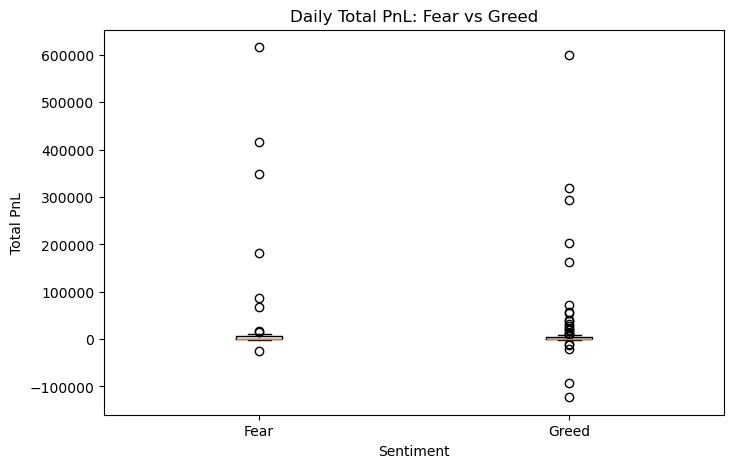

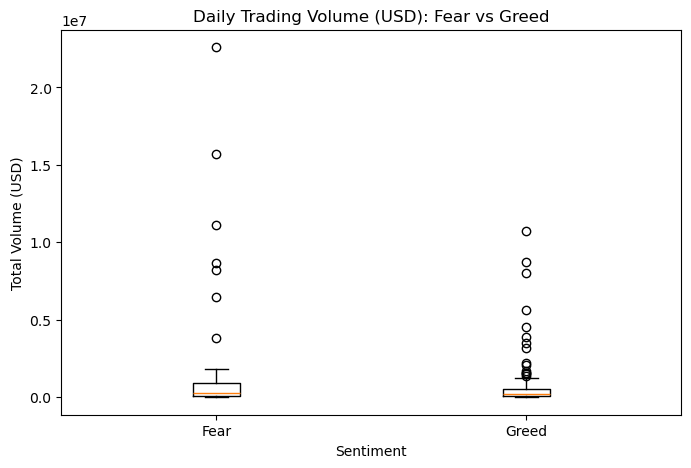

In [43]:
import matplotlib.pyplot as plt

# PnL Boxplot
fear = merged.loc[merged["sentiment"] == "Fear", "total_pnl"].dropna()
greed = merged.loc[merged["sentiment"] == "Greed", "total_pnl"].dropna()

plt.figure(figsize=(8,5))
plt.boxplot([fear, greed], labels=["Fear", "Greed"])
plt.title("Daily Total PnL: Fear vs Greed")
plt.xlabel("Sentiment")
plt.ylabel("Total PnL")
plt.show()

# Volume Boxplot
fear_vol = merged.loc[merged["sentiment"] == "Fear", "total_volume_usd"].dropna()
greed_vol = merged.loc[merged["sentiment"] == "Greed", "total_volume_usd"].dropna()

plt.figure(figsize=(8,5))
plt.boxplot([fear_vol, greed_vol], labels=["Fear", "Greed"])
plt.title("Daily Trading Volume (USD): Fear vs Greed")
plt.xlabel("Sentiment")
plt.ylabel("Total Volume (USD)")
plt.show()


In [44]:
behavior = trades.merge(sentiment[["date", "sentiment"]], left_on="date_correct", right_on="date", how="inner")

trader_perf = behavior.groupby("sentiment").agg(
    total_pnl=("closed_pnl", "sum"),
    avg_trade_pnl=("closed_pnl", "mean"),
    total_volume=("size_usd", "sum"),
    total_trades=("trade_id", "count")
).round(4)

display(trader_perf)


,total_pnl,avg_trade_pnl,total_volume,total_trades
sentiment,,,,
Fear,1.783626e+06,110.1343,89254631.10,16195
Greed,1.841183e+06,93.6084,87209127.22,19669
